# Classification of molecules by aqueous solubility


Here, we will use machine learning to create a simple model to predict whether a molecule is soluble in water or not. This is a classification task, and we will train (and evaluate) different types of models based on a published dataset.

_This notebook is inspired by Pat Walters: https://github.com/PatWalters/chem_tutorial/blob/main/tutorial_03_eda.ipynb_

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Machine learning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
set_config(display='diagram')

The data we will be using is from the paper “AqSolDB, a curated reference set of aqueous solubility and 2D descriptors for a diverse set of compounds”, M.C. Sorkun, A. Khetan and S. Er, _Scientific Data_, **2019**, 6, 143, DOI: [10.1038/s41597-019-0151-1](https://doi.org/10.1038/s41597-019-0151-1)

The goal of the authors in developing this dataset and making it available is stated in their abstract:

> _we generated a new database of compounds, AqSolDB, by merging a total of nine different aqueous solubility datasets, curating the merged data, standardizing and validating the compound representation formats, marking with reliability labels, and providing 2D descriptors of compounds as a Supplementary Resource_

and their “usage notes” section:

> The availability of the calculated 2D descriptors makes it possible to directly use the data for developing machine learning models.

The authors also made available the code that they used to generate the dataset, from other existing datasets, including curation steps: https://doi.org/10.24433/CO.1992938.v1 This is very good open science practice, allowing reproducible research!

If you are interested in this topic, I encourage you to go read the paper and the associated code. Here, we will directly use their data (solubility, list of molecules and associated molecular descriptors) to train a machine learning algorithm for a classification task.

In [2]:
df = pd.read_csv("curated-solubility-dataset.csv")

## Content of the dataset

We have read a local copy of the data set.

We first examine the content of the data set: how many records (molecules) does it have? What information is present for each? What is the type and range of the various descriptors?

In [3]:
print('Number of records:', len(df))
print('Number of columns:', len(df.keys()))
print('Overview of the first records:')
df.head()

Number of records: 9982
Number of columns: 26
Overview of the first records:


,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


In [4]:
df.describe()

,Solubility,SD,Ocurrences,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
count,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000,9982.000000
mean,-2.889909,0.067449,1.378081,266.665946,1.979167,66.794594,17.374674,3.486776,1.108595,5.196955,4.073031,94.243438,1.068323,0.292627,0.447606,1.515929,62.458601,108.912586,2.392199,467.336782
std,2.368154,0.234702,1.023476,184.179024,3.517738,46.523021,12.241536,3.498203,1.488973,4.736275,5.646925,64.748563,1.309427,0.879599,1.054667,1.644334,63.348307,76.462726,1.091123,546.631696
min,-13.171900,0.000000,1.000000,9.012000,-40.873200,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.504228,-0.000004,0.000000
25%,-4.326325,0.000000,1.000000,162.276000,0.619750,40.602475,11.000000,2.000000,0.000000,3.000000,1.000000,58.000000,0.000000,0.000000,0.000000,0.000000,26.300000,66.623721,2.004357,163.243343
50%,-2.618173,0.000000,1.000000,228.682000,1.949220,58.633400,15.000000,3.000000,1.000000,4.000000,3.000000,82.000000,1.000000,0.000000,0.000000,1.000000,50.720000,93.299873,2.539539,351.640433
75%,-1.209735,0.000000,1.000000,320.436000,3.419030,81.938000,21.000000,4.000000,2.000000,6.000000,5.000000,112.000000,2.000000,0.000000,1.000000,2.000000,80.390000,129.118374,3.032456,606.562848
max,2.137682,3.870145,38.000000,5299.456000,68.541140,1419.351700,388.000000,86.000000,26.000000,89.000000,141.000000,2012.000000,35.000000,30.000000,30.000000,36.000000,1214.340000,2230.685124,7.517310,20720.267708


Some data fields describe the molecules and their structure:
- `Name` is the molecule name (not sure if common or IUPAC name)
- `InChI` and `InChIKey` are (see [Wikipedia](https://en.wikipedia.org/wiki/International_Chemical_Identifier))
- `SMILES` is the (see [Wikipedia](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system))

Then there are 17 molecular descriptors, calculated from the molecular structure by `RDKit` and listed in the paper (Table 2):

| Name | Description | Type |
| :- | :- | :- |
| MolWt | Molecular weight | float |
| MolLogP | Octanol-water partition coefficient | float |
| MolMR | Molar refractivity | float |
| HeavyAtomCount | Number of non-H atoms | integer |
| NumHAcceptors | Number of H acceptors | integer |
| NumHDonors | Number of H donors | integer |
| NumHeteroatoms | Number of atoms not carbon or hydrogen | integer |
| NumRotatableBonds | Number of rotatable bonds | integer |
| NumValenceElectrons | Number of valence electrons | integer |
| NumAromaticRings | Number of aromatic rings | integer |
| NumSaturatedRings | Number of saturated rings | integer |
| NumAliphaticRings | Number of aliphatic rings | integer |
| RingCount | Number of total rings | integer |
| TPSA | Topological polar surface area | float |
| LabuteASA | Labute’s Approximate Surface Area | float |
| BalabanJ | Balaban’s J index (graph index) | float |
| BertzCT | A topological complexity index of compound | float |

Finally, there is data about the solubility. `Solubility` is the experimental aqueous solubility value (LogS, actually). And because the dataset was obtained by merging together different sources, some solubility values come from different independent measurements. `Occurrences` is the number of measurements for each molecule, and `SD` is the standard deviation between measurements. Finally, each molecular is assigned a reliability group (`Group`).

- G1 - occurs once in the dataset
- G2 - occurs twice in the dataset, values are considered different (SD > 0.5)
- G3 - occurs twice in the dataset, values are considered consistent (SD <= 0.5)
- G4 - occurs 3+ times in the dataset, values are considered different (SD > 0.5)
- G5 - occurs 3+ times in the dataset, values are considered consistent (SD <= 0.5)

## Selection / curation of the data

We probably want to restrict our analysis to some of the data, keeping only the records that we consider the most reliable. How many molecules are in each group?

In [5]:
df['Group'].value_counts()

G1    7746
G3    1182
G5     636
G2     235
G4     183
Name: Group, dtype: int64

We probably want to exclude molecules in the G2 and G4 groups: their solubility has been measured several times, with quite different values, so those values have high uncertainty. But what about G1? 

In [6]:
print('Molecules in G3 + G5:', sum(df['Group'].isin(['G3', 'G5'])))
print('Molecules in G1 + G3 + G5:', sum(df['Group'].isin(['G1', 'G3', 'G5'])))

Molecules in G3 + G5: 1818
Molecules in G1 + G3 + G5: 9564


Most of our dataset is from molecules in the G1 group, where the solubility value is derived from a single measurement. For those, we have no idea of the reliability of the data. On the other hand, if we exclude them, our dataset size goes down from 9564 to 1818. What is best for our machine learning model? More data to train on, or less data but with better accuracy?

There is no universal choice, really. In this tutorial, we will start by keeping only the more accurate data, for now.

In [7]:
df1 = df[df['Group'].isin(['G3', 'G5'])]
print('Number of records in df1:', len(df1))

Number of records in df1: 1818


## Exploring the data

We can have a look at the distribution of the solubility values in the data set:

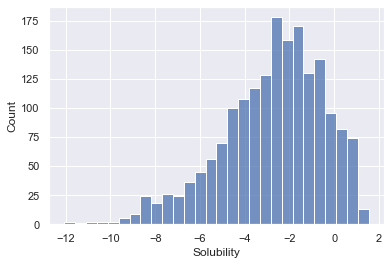

In [8]:
_ = sns.histplot(data=df1, x='Solubility')

Or visually inspect the data to try and see how different descriptors appear to correlate with the solubility:

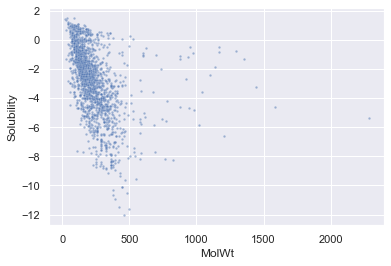

In [9]:
_ = sns.scatterplot(data=df1, x='MolWt', y='Solubility', s=6, alpha=0.5)

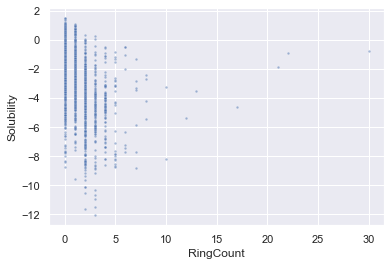

In [10]:
_ = sns.scatterplot(data=df1, x='RingCount', y='Solubility', s=6, alpha=0.5)

In [11]:
# Your code here :)

You can play around with different descriptors… can you guess which is going to be the most important one? 

## Setting up a classification problem

We currently have as data a series of numerical descriptors for each molecule, and a value of solubility. We could therefore create a **regression model**, which would predict the value of solubility constant (a continuous variable).

But suppose, for our purposes, we are not interested in the exact value of the solubility constant, but only on whether a molecule is soluble or not in water. This is then a **classification model**, where the outcome we want to predict is a discrete label or category: soluble or insoluble.

We therefore start by creating these categories. We define a molecule as soluble in water if its solubility is higher than 200 μM.

In [12]:
def isSoluble(s):
    return 'yes' if s > np.log10(200e-6) else 'no'

df['Soluble'] = df['Solubility'].apply(isSoluble)

Having modified the whole dataset `df`, we need to extract again our restricted dataset of high accuracy data `df1`

In [13]:
df1 = df[df['Group'].isin(['G3', 'G5'])]

And we can check that the data distribution between soluble and insoluble molecules is not too unbalanced:

Number of soluble molecules: 1260
Number of insoluble molecules: 558


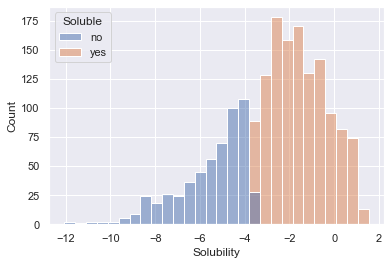

In [14]:
print('Number of soluble molecules:', sum(df1['Soluble'] == 'yes'))
print('Number of insoluble molecules:', sum(df1['Soluble'] == 'no'))
_ = sns.histplot(data=df1, x='Solubility', hue='Soluble')

We see that there are more soluble molecules than insoluble molecules in the dataset, but both sets contain enough molecules that we are able to use the data for prediction.

We are going to train different types of models for this classification task. In order to evaluate their statistical accuracy, we are going to split the entire data set between a **training set** and a **testing set**. Scikit-learn has a function for that: [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

This is a relatively simple way to measure accuracy, and suitable for this simple example. We could also use more advanced procedures, such as **[cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)**.

In [15]:
train, test = train_test_split(df1, random_state=42)
print('Records in training data:', len(train))
print('Records in testing data:', len(test))

Records in training data: 1363
Records in testing data: 455


We will now store separately our training features (the descriptors), training targets (the classes to predict: yes/no), testing features and testing targets.

We start by illustrating the process with very simple data, restricted to only two descriptors: molecular weight and number of aromatic rings.

In [16]:
data_train = train[['MolWt', 'NumAromaticRings']]
data_test = test[['MolWt', 'NumAromaticRings']]

target_train = train['Soluble']
target_test = test['Soluble']

## First model: logistic regression

As our first model, we choose a very simple example: a [logistic regressor](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), which is a linear model for classification. (And yes, despite its name, it is a _classification_ model and not a _regression_ model. I agree that it is confusing.)

We create a two-step pipeline for this model:
1. standardization of the features
2. logistic regression

In the regressor, we set the `penalty` parameter to `none`, so there is no regularization of the model (no constraint on the coefficients of the model). This makes the logistic regression behave as a purely linear model, and will be simpler for discussion later.

In [17]:
logistic_regression = make_pipeline(
    StandardScaler(), LogisticRegression(penalty='none')
)
logistic_regression.fit(data_train, target_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(penalty='none'))])

Once the model was trained, we measure its accuracy on testing data:

In [18]:
train_accuracy = logistic_regression.score(data_train, target_train)
print('Accuracy on training dataset:', train_accuracy)

test_accuracy = logistic_regression.score(data_test, target_test)
print('Accuracy on test dataset:', test_accuracy)

Accuracy on training dataset: 0.7850330154071901
Accuracy on test dataset: 0.7956043956043956


This accuracy is the percentage of correct predictions: it is ~80% in this case, based on test data.

To what do we compare this accuracy? After all, in a game of “heads or tails”, even guessing randomly has a 50% accuracy. Here, we will compare the accuracy to the performance of a so-called **dummy classifier**, i.e. a model that would always predict the most common label.

In [19]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(data_train, target_train)

test_accuracy = dummy.score(data_test, target_test)
print('Accuracy of dummy classifier:', test_accuracy)

Accuracy of dummy classifier: 0.7274725274725274


Here, this dummy classifier is a model that predicts all molecules to be soluble (because it is the most frequent category). And because 73% of molecules in our test data set are soluble, that “stupid” model has 73% accuracy. So we see that our logistic regression model performance is a little bit better (but not a lot) than the dummy classifier.

Let's see if a different choice of descriptors would make a difference to the model accuracy: we'll take molar weight and this `MolLogP` descriptor now (more on that below):

In [20]:
data_train = train[['MolWt', 'MolLogP']]
data_test = test[['MolWt', 'MolLogP']]

target_train = train['Soluble']
target_test = test['Soluble']

In [21]:
logistic_regression = make_pipeline(
    StandardScaler(), LogisticRegression(penalty='none')
)
logistic_regression.fit(data_train, target_train)

train_accuracy = logistic_regression.score(data_train, target_train)
print('Accuracy on training dataset:', train_accuracy)

test_accuracy = logistic_regression.score(data_test, target_test)
print('Accuracy on test dataset:', test_accuracy)

Accuracy on training dataset: 0.8708730741012473
Accuracy on test dataset: 0.8967032967032967


The accuracy has definitely gone up, with those two descriptors it's now at about 90%. We can also check and confirm that training accuracy and test accuracy are comparable, so our model does not appear to be overfitting (which is expected from having only two features).

Because we only have two descriptors, we can actually plot the data in this space:

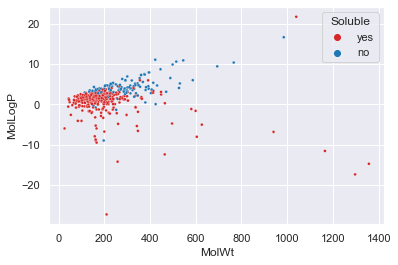

In [22]:
_ = sns.scatterplot(data=test, x='MolWt', y='MolLogP', hue='Soluble', palette=['tab:red', 'tab:blue'], s=8)

In this 2D feature space, we can also plot the decision function of our trained model. There is no ready-made function for this, so we create our own below. _The details of the code are not directly relevant, so you can skip to the resulting graph…_

In [23]:
range_features = {
    feature_name: (df1[feature_name].min() - 1,
                   df1[feature_name].max() + 1)
    for feature_name in ['MolWt', 'MolLogP']
}

def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], 10),
        np.arange(*range_features[feature_names[1]], 0.2),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu_r')

    return ax

/Users/fx/conda3/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


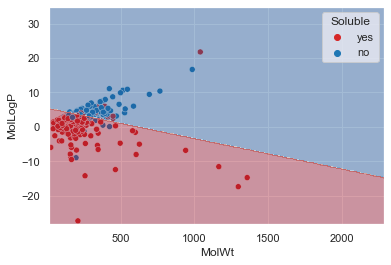

In [24]:
ax = sns.scatterplot(
    data=test, x='MolWt', y='MolLogP',
    hue='Soluble', palette=['tab:red', 'tab:blue'])
_ = plot_decision_function(logistic_regression, range_features, ax=ax)

Let’s discuss that graph for a minute. Why does the decision function for the logistic regression model look like this?

As we have seen before, a _linear regression_ model will predict a continuous target, as a linear function of features. But classification tasks can be carried out with linear models, as well. When the target is a binary outcome, we use (like here) a logistic function to model the probability of each outcome, and this is why this model is known as **logistic regression**. For each point, the classifier will then predict the outcome that it finds *most likely*.

We plotted above the decision function, red for soluble and blue for insoluble. The edge of that decision function is the curve separating the two areas, where the probability of each is 1/2. In our _logistic regression_ model, it 
is a straight line.

We noted earlier that we did not impose any _regularization_ by setting the parameter `penalty` to `None`. This allows the fitting to allow coefficients as big (or small) as needed. Since the line is oblique, it means that the model uses a combination of both features. We can find the coefficient of each feature in the equation, which will give us an idea of their weight/importance.

In [25]:
c = logistic_regression['logisticregression'].coef_[0]
print('1st feature (MolWt):', c[0])
print('2nd feature (MolLogP):', c[1])

1st feature (MolWt): -1.0934625384706609
2nd feature (MolLogP): -2.7083387616779944


And we see that `MolLogP` is the most important feature in the classification.

Can we make chemical sense of this? `MolLogP` was calculated by RDKit, where it is described as an “atom-based calculation of the octanol/water partition coefficient log(_P_)”. More accurately, it is an _approximation_ of log(_P_), based on [this paper](https://doi.org/10.1021/ci990307l) by Wildman and Crippen. The approximation is designed to sum contribution from different types of atoms present in a molecule, and coefficients for it were trained against existing experimental data.

Of course, water solubility and octanol/water separation are related, so it makes a lot of sense that `MolLogP` would be an important descriptor for water solubility.

## More descriptors

As seen above, the `MolLogP` molecular descriptor is very well-suited for the prediction of solubility. But using it feels like cheating a bit, since its formula was itself trained by statistical methods on experimental data (which is, in itself, a learning process). So we ask the question: can we achieve the same model accuracy by using other descriptors?

In [26]:
otherDescriptors = ['BalabanJ', 'BertzCT', 'HeavyAtomCount', 'LabuteASA', 'MolMR',
  'MolWt', 'NumAliphaticRings', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors',
  'NumHeteroatoms', 'NumRotatableBonds',  'NumSaturatedRings',  'NumValenceElectrons',
  'RingCount', 'TPSA']

We are making a function that will train a model for each descriptor, and give us as result the accuracy measured on the test dataset:

In [27]:
def modelAccuracy(descriptors):
    data_train = train[descriptors]
    data_test = test[descriptors]

    logistic_regression = make_pipeline(
        StandardScaler(), LogisticRegression(penalty='none')
    )
    logistic_regression.fit(data_train, target_train)

    return logistic_regression.score(data_test, target_test)

In [28]:
for d in otherDescriptors:
    print(f'Accuracy with {d}: {modelAccuracy([d]):.3f}')

Accuracy with BalabanJ: 0.727
Accuracy with BertzCT: 0.749
Accuracy with HeavyAtomCount: 0.752
Accuracy with LabuteASA: 0.771
Accuracy with MolMR: 0.793
Accuracy with MolWt: 0.774
Accuracy with NumAliphaticRings: 0.721
Accuracy with NumAromaticRings: 0.767
Accuracy with NumHAcceptors: 0.727
Accuracy with NumHDonors: 0.727
Accuracy with NumHeteroatoms: 0.719
Accuracy with NumRotatableBonds: 0.741
Accuracy with NumSaturatedRings: 0.725
Accuracy with NumValenceElectrons: 0.749
Accuracy with RingCount: 0.756
Accuracy with TPSA: 0.727


Many of these descriptors, alone, produce models that are not statistically better than the “dummy classifier” which is our baseline. But how do they perform when put all together?

In [29]:
data_train = train[otherDescriptors]
data_test = test[otherDescriptors]

logistic_regression = make_pipeline(
    StandardScaler(), LogisticRegression(penalty='none')
)
logistic_regression.fit(data_train, target_train)

test_accuracy = logistic_regression.score(data_test, target_test)
print('Test accuracy:', test_accuracy)

Test accuracy: 0.8791208791208791


So we can indeed create a model with descriptors other than `MolLogP`, that can statistically reach the same accuracy (or almost)!

What are the features that contribute the most to this model?

In [30]:
logistic_regression['logisticregression'].coef_

array([[-0.32212159,  3.58979993, -3.7847206 , -0.37756608, -1.63698465,
        -1.23614699, -0.47265552, -0.74080579,  0.87183295,  0.84587423,
        -0.47313289,  0.59245227,  0.85485127,  1.47958298, -0.86713031,
         0.3928599 ]])

Let's display this list of coefficients more nicely:

In [31]:
coefficients = logistic_regression['logisticregression'].coef_[0]

for name, coeff in zip(otherDescriptors, coefficients):
    print(f'{name}: {coeff:.3f}')

BalabanJ: -0.322
BertzCT: 3.590
HeavyAtomCount: -3.785
LabuteASA: -0.378
MolMR: -1.637
MolWt: -1.236
NumAliphaticRings: -0.473
NumAromaticRings: -0.741
NumHAcceptors: 0.872
NumHDonors: 0.846
NumHeteroatoms: -0.473
NumRotatableBonds: 0.592
NumSaturatedRings: 0.855
NumValenceElectrons: 1.480
RingCount: -0.867
TPSA: 0.393


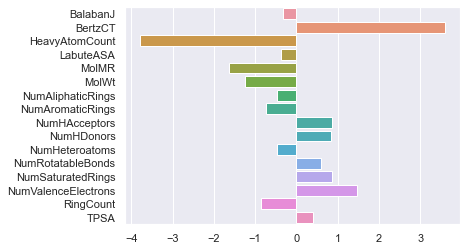

In [32]:
_ = sns.barplot(x=coefficients, y=otherDescriptors)

## What type of errors are we making? Confusion matrix

We have calculated before a statistical accuracy of the predictor. But in a classification task, there are different types of mispredictions, and we may want to check those. For example, in some applications we could be interested to minimize specifically _false positives_ or _false negatives_.

We can obtain detailed information by calculating and displaying the **[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)** for the model.

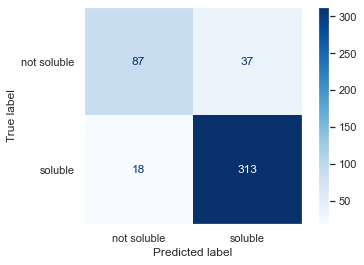

In [33]:
ConfusionMatrixDisplay.from_estimator(
    logistic_regression, data_test, target_test, display_labels=['not soluble', 'soluble'],
    normalize=None, cmap=plt.cm.Blues
)
plt.grid(False)
plt.show()

We can see that, in this case, we tend to predict more insoluble molecules as soluble, than we predict soluble molecules as insoluble. We can link this trend to the nature of the training data set, which is biased towards soluble molecules.

## Multiclass classification

The characterization of confusion matrices is also very interesting when we have multiclass classification tasks. The logistic regression algorithm can also be used for multi-class classification. We are going to test this by defining the solubility of molecules in 3 classes:
- highly soluble (> 1 mM)
- medium solubility (30 μM to 1 mM)
- low solubility (< 30 μM)

In [34]:
def isSoluble3(s):
    if s > np.log10(1e-3):
        return 'high'
    elif s > np.log10(30e-6):
        return 'medium'
    else:
        return 'low'

df['Soluble3'] = df['Solubility'].apply(isSoluble3)

We are also going to use now a bigger dataset, this time by introducing the data in G1 group (where only one experimental measurement of solubility is available):

In [35]:
df2 = df[df['Group'].isin(['G1', 'G3', 'G5'])]

Let’s see how this new data looks like:

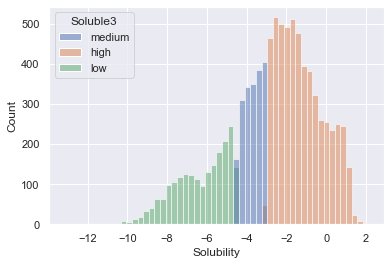

In [36]:
_ = sns.histplot(data=df2, x='Solubility', hue='Soluble3')

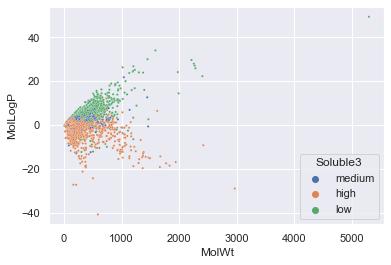

In [37]:
_ = sns.scatterplot(data=df2, x='MolWt', y='MolLogP', hue='Soluble3', s=5)

The workflow now should be familiar to you, but you can make changes and experiment!

In [38]:
train, test = train_test_split(df2, random_state=42)
print('Records in training data:', len(train))
print('Records in testing data:', len(test))


Records in training data: 7173
Records in testing data: 2391


In [39]:
data_train = train[otherDescriptors]
data_test = test[otherDescriptors]

target_train = train['Soluble3']
target_test = test['Soluble3']

In [40]:
logistic_regression = make_pipeline(
    StandardScaler(), LogisticRegression(penalty='none')
)
_ = logistic_regression.fit(data_train, target_train)

/Users/fx/conda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


⚠️ That error is not usual, though. What is happening? Because we have more data (and many descriptors), the numerical procedure for the fitting of the linear model did not converge within the default number of iterations. We have to increase that number (`max_iter`) from 100 to 500:

In [41]:
logistic_regression = make_pipeline(
    StandardScaler(), LogisticRegression(penalty='none', max_iter=500)
)
logistic_regression.fit(data_train, target_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=500, penalty='none'))])

In [42]:
train_accuracy = logistic_regression.score(data_train, target_train)
print('Train accuracy:', train_accuracy)

test_accuracy = logistic_regression.score(data_test, target_test)
print('Test accuracy:', test_accuracy)

# What about the accuracy of a dummy classifier?
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(data_train, target_train)

test_accuracy = dummy.score(data_test, target_test)
print('Accuracy of dummy classifier:', test_accuracy)

Train accuracy: 0.7038895859473023
Test accuracy: 0.698452530322041
Accuracy of dummy classifier: 0.5771643663739021


So the accuracy for our “simple” linear model is now lower for 3-way classification than for binary classification. But what about the confusion matrix?

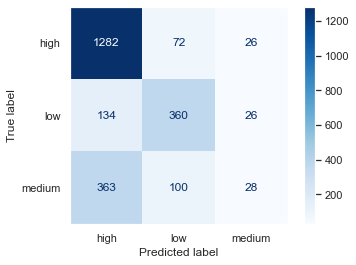

In [43]:
ConfusionMatrixDisplay.from_estimator(
    logistic_regression, data_test, target_test,
    normalize=None, cmap=plt.cm.Blues
)
plt.grid(False)
plt.show()

We can see what is happening: the model has a hard time predicting “medium” solubility: predictions for both low and high solubility have higher accuracy, but most of the records whose true label is medium, are predicted as either high or low (but not medium).

Maybe a linear model is not ideal for this task. Could another type of model perform better?

## Using a nearest neighbors model

Another category of classification models is that of [nearest neighbors methods](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification). It is a type of **non-parametric learning**, in that it does not attempt to find ideal parameters in an general internal model (like a linear model). Instead, the “training” simply stores a copy of the training data, and classification is done by looking this data up.

> _Nonparametric methods are good when you have a lot of data and no prior knowledge, and when you don’t want to worry too much about choosing just the right features._ ([Artificial Intelligence: A Modern Approach](http://aima.cs.berkeley.edu))

In neighbors-based methods, classification is computed from a simple majority vote of the nearest neighbors of the point to be predicted. The $k$-nearest neighbors classification ([`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)) is the most common technique: for each new point, it will predict based on a fixed number ($k$) of neighbors in the training data.

In [44]:
kNN = make_pipeline(
    StandardScaler(), KNeighborsClassifier(n_neighbors=5)
)

In [45]:
kNN.fit(data_train, target_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

We see that, even though the model chosen is very different in nature (kNN instead of logistic regression), the workflow remains the same, and the `scikit-learn` functions are the same:
- create a pipeline, combining normalization and a ML model
- call the `fit` function on training data
- call the `score` function on test data

In [46]:
test_accuracy = kNN.score(data_test, target_test)
print('Test accuracy:', test_accuracy)

Test accuracy: 0.7595148473442075


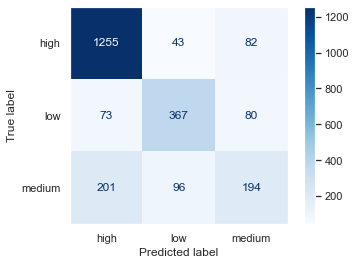

In [47]:
ConfusionMatrixDisplay.from_estimator(
    kNN, data_test, target_test,
    normalize=None, cmap=plt.cm.Blues
)
plt.grid(False)
plt.show()

The accuracy is actually well improved! The $k$-nearest neighbors classifier has an accuracy of 76% (up from 70% for the logistic regression). We see in particular that it improved the quality of prediction for the “medium” solubility significantly… although it is still not ideal.

## Going further…

Based on the dataset given here, we have introduced classification tasks (both binary and multi-class) and see two algorithms at play. Here are some directions that you might want to explore in the future:

- The $k$-nearest neighbors method depends on one crucial hyperparameter: $k$. How does the number of neighbors impact the model? What happens for very small and very large values of $k$? For this data set, what is the value that provides the best accuracy?
- Another family of classification algorithms are [decision trees](https://scikit-learn.org/stable/modules/tree.html). They are relatively easy to understand and interpret. Can you train a decision tree for this task? How does the accuracy compare with other models? Does an ensemble method (like a [random forest](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)) perform better than a single decision tree?
- How do the models produced for the “small” (highly accurate) data set and “big” data set compare? Can we make statistical comparisons between the values present in both data sets?
- We have set up our problem as a classification task by defining cut-off values of solubility for soluble and insoluble molecules. Could we, as an alternative, use the same solubility data to create a _regression_ task? How would the resulting predictions compare?